# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os
import os.path as op
import shutil
import bokeh

# standard third party imports
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder

# impute missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
import sys

In [51]:
import panel as pn
pn.extension('bokeh')

bokeh extension not recognized and will be skipped.


In [52]:
#standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning, initialize_environment,
    get_package_path, display_as_tabs, save_data, save_pipeline, load_dataframe, load_pipeline, load_dataset, DEFAULT_ARTIFACTS_PATH
)
import ta_lib.core.api as dataset
import ta_lib.eda.api as ta_analysis
from ta_lib.reports.api import create_report
import ta_lib.reports.api as health
from sklearn.ensemble import RandomForestClassifier
from ta_lib.classification.api import ClassificationComparison, ClassificationReport, confusion_matrix_by_feature, SKLStatsmodelLogit
from ta_lib.data_processing.api import Outlier, WoeBinningTransformer

from scripts import * 

os.environ['TA_DEBUG'] = "False"
os.environ['TA_ALLOW_EXCEPTIONS'] = "True"

# Initialization
initialize_environment(debug=False, hide_warnings=True)

In [53]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', message="bokeh extension not recognized and will be skipped.")
warnings.filterwarnings('ignore', message="The sklearn.metrics.classification module", category=FutureWarning)
warnings.filterwarnings('ignore', message=".*title_format is deprecated. Please use title instead.*")

In [54]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

# Initialization

In [111]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [112]:
display_as_tabs([('config', context.config)])

Tabs
    [0] JSON(dict, name='config')

# 3 EDA

Here we are doing a preliminary EDA on the dataset to add any features and findings

## 3.1 Read the Train and Test Data

In [113]:
train_X = load_dataset(context, 'train/merged/features')
train_y = load_dataset(context, 'train/merged/target')

test_X = load_dataset(context, 'test/merged/features')
test_y = load_dataset(context, 'test/merged/target')

# train_customers=train_X['oppo_pro_tr_time_geo_id'].tolist()
# test_customers=train_X['oppo_pro_tr_time_geo_id'].tolist()
# ref_date_for_churn = r'2013-05-01'
# ref_date=pd.to_datetime(ref_date_for_churn)

num_columns = train_X.select_dtypes('number').columns

In [114]:
display_as_tabs([('train features old', train_X.shape), ('test features old', test_X.shape)])

Tabs
    [0] Str(tuple, name='train features old')
    [1] Str(tuple, name='test features old')

## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Feature Generation
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Inputation

### 3.2.1 Custom Feature Generation

Model data is at customer level. Most of the other data sources are at customer, year, month level. Thus these data have to be aggregated to relevant features to be added to the model.

Feature that can be extracted from the data sources are as follows:

| | Dataset | DataFrame | Column | Features | 
|-|---------|-----------|----------|--|
|1| Primary sales |pri_bpm_df | `pri_sales_amount` | Last 6 months mean <br> Last 3 months mean <br>   Overall average WOE binned | 
| 2| Secondary sales  |sec_bpm_df | `sec_ind_bpm_actuals` | Overall mean <br> Last 6 months mean <br>  last 3 months mean| 
| 3| No objection data | no_obj_df | `policy_flag` | Counts wrt policy_flag category |
| 4 |  Orders data | order_alloc_df | `simple avg allocated percent` | Overall average |
| 5 | Orders and allocated reasons data | orders_and_allocated_reason_df | `reason_code_description_new_new` | Percentage allocated by category|
| 6| Returns or profit data | returns_df | `profit_with_udaan_without_sub` <br> `profit_without_udaan_sub`  <br> `profit_with_udaan_with_sub`  <br>  `profit_without_udaan_without_sub`  <br> `roi_without_udaan_sub`  <br>  `roi_with_udaan_without_sub`  <br> `roi_without_udaan_with_sub`  <br> `roi_with_udaan_with_sub` | Last 6 months mean <br> Overall mean| 
| | | |`roi_without_udaan_with_sub` | Overall woebinned | 
| 7 | Coverage data | coverage_df | `daily_coverage_perc` | Last 6 months values |
| 8 | Retail program data | retail_program_df | `sec_netvalue` <br>  `bandhan_net_val` <br> `wholesale_net_value` <br> `otherpgrm_net_val` <br> `non_wholesale_net_value` | Last 6 months mean <br> last 3 months mean <br>  Overall mean| 
| 9 | Business data | ec_df | `ec` | Last 3 months mean <br> Last 6 months mean <br> Overall mean | 
|10 | Ordered with apps | ordered_with_app_df | `labor_in_person_days` | Last 6 months mean <br> Last 3 months mean <br> Overall mean |
| 11|  Ordered without apps | ordered_without_app_df | `labor_in_person_days` | Last 6 months mean <br> Last 3 months mean <br> Overall mean |
|12| Retail invoices | dist_retail_invoice_df | `unique_retailers` <br> `invoice_count` | Last 6 months mean <br> Last 3 months mean <br> overall mean |
| 13| Days_in_business | doj_df | | `ref_date` - `date_of_joining`| 

Functions used to generate these features are available in scripts.py. **Note:** these follow pyjanitor style of coding. For more details refer [here](https://pyjanitor.readthedocs.io/notebooks/pyjanitor_intro.html)

In [59]:
# agg_methods = {'primary_sales': {'agg_type': ['rolling', 'cumulative'],
#                                  'feature_col': 'pri_sales_amount',
#                                  'data_path': "/cleaned/pri_bpm",
#                                 'window': [3,6],
#                                 'method': 'mean',
#                                 'group_by_col': 'customer_code'},
#               'secondary_sales': {'agg_type': ['rolling', 'cumulative'],
#                                   'feature_col': 'sec_ind_bpm_actuals',
#                                  'data_path': "/cleaned/sec_bpm",
#                                   'window': [3,6],
#                                   'method': 'mean',
#                                   'group_by_col': 'customer_code'},
#                'order_alloc': {'agg_type': ['cumulative'],
#                                'feature_col': 'simple avg allocated percent',
#                                'data_path': "/cleaned/order_alloc",
#                                'window': None,
#                                'method': 'mean',
#                                'group_by_col': 'customer_code'},
#                'coverage_data': {'agg_type': ['rolling'],
#                                  'feature_col': 'daily_coverage_perc',
#                                  'data_path': "/cleaned/coverage",
#                                  'window': [6],
#                                  'method': 'mean',
#                                  'group_by_col': 'customer_code'},
#                'profit_data': {'agg_type': ['rolling', 'cumulative'],
#                                 'window': [3,6],
#                                'method': 'mean',
#                                'group_by_col': 'customer_code'},
#                'retail_program': {'agg_type': ['rolling', 'cumulative'],
#                                    'window': [3,6],
#                                   'method': 'mean',
#                                   'group_by_col': 'customer_code'},
#                'business_data': {'agg_type': ['rolling', 'cumulative'],
#                                  'feature_col': 'ec',
#                                  'data_path': "/cleaned/ec",
#                                  'window': [3,6],
#                                  'method': 'mean',
#                                  'group_by_col': 'customer_code'},
#                'app_order_data':  {'agg_type': ['rolling'],
#                                    'feature_col': 'labor_in_person_days',
#                                    'data_path': "/cleaned/ordered_with_app",
#                                    'window': [3,6],
#                                    'method': 'mean',
#                                    'group_by_col': 'customer_code'},
#                'withoutapp_order_data':  {'agg_type': ['rolling'],
#                                           'feature_col': 'labor_in_person_days',
#                                           'data_path': "/cleaned/ordered_without_app",
#                                           'window': [3,6],
#                                           'method': 'mean',
#                                           'group_by_col': 'customer_code'},
#                'retail_data': {'agg_type': ['rolling'],
#                                'window': [3,6],
#                                'method': 'mean',
#                                'group_by_col': 'customer_code'}}

In [12]:
# def add_features(df, context, ref_date):
#     data = (
#         df.add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["primary_sales"]["feature_col"],
#                 data_path=agg_methods["primary_sales"]["data_path"],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["primary_sales"]["agg_type"],
#                 windows=agg_methods["primary_sales"]["window"],
#                 group_by_col=agg_methods["primary_sales"]["group_by_col"],
#                 agg_method=agg_methods["primary_sales"]["method"]) \
#           .add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["secondary_sales"]['feature_col'],
#                 data_path=agg_methods["secondary_sales"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["secondary_sales"]["agg_type"],
#                 windows=agg_methods["secondary_sales"]["window"],
#                 group_by_col=agg_methods["secondary_sales"]["group_by_col"],
#                 agg_method=agg_methods["secondary_sales"]["method"],) \
#             .add_features_no_objection_data(context, ref_date)
#             .add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["order_alloc"]['feature_col'],
#                 data_path=agg_methods["order_alloc"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["order_alloc"]["agg_type"],
#                 windows=agg_methods["order_alloc"]["window"],
#                 group_by_col=agg_methods["order_alloc"]["group_by_col"],
#                 agg_method=agg_methods["order_alloc"]["method"],) \
#             .add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["coverage_data"]['feature_col'],
#                 data_path=agg_methods["coverage_data"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["coverage_data"]["agg_type"],
#                 windows=agg_methods["coverage_data"]["window"],
#                 group_by_col=agg_methods["coverage_data"]["group_by_col"],
#                 agg_method=agg_methods["coverage_data"]["method"],) \
#             .add_features_profit_data(
#                 context,
#                 ref_date,
#                 agg_type=agg_methods["profit_data"]["agg_type"],
#                 windows=agg_methods["profit_data"]["window"],
#                 group_by_col=agg_methods["profit_data"]["group_by_col"],
#                 agg_method=agg_methods["profit_data"]["method"],) \
#             .add_features_order_alloc_reason(context, ref_date)
#             .add_features_retail_program_data(
#                 context,
#                 ref_date,
#                 agg_type=agg_methods["retail_program"]["agg_type"],
#                 windows=agg_methods["retail_program"]["window"],
#                 group_by_col=agg_methods["retail_program"]["group_by_col"],
#                 agg_method=agg_methods["retail_program"]["method"],) \
#             .add_time_features(
#                 context,
#                 date_col='month_start_date',
#                 features_col=agg_methods["business_data"]['feature_col'],
#                 data_path=agg_methods["business_data"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["business_data"]["agg_type"],
#                 windows=agg_methods["business_data"]["window"],
#                 group_by_col=agg_methods["business_data"]["group_by_col"],
#                 agg_method=agg_methods["business_data"]["method"],) \
#             .add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["app_order_data"]['feature_col'],
#                 data_path=agg_methods["app_order_data"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["app_order_data"]["agg_type"],
#                 windows=agg_methods["app_order_data"]["window"],
#                 group_by_col=agg_methods["app_order_data"]["group_by_col"],
#                 agg_method=agg_methods["app_order_data"]["method"],) \
#             .add_time_features(
#                 context,
#                 date_col="month_start_date",
#                 features_col=agg_methods["withoutapp_order_data"]["feature_col"],
#                 data_path=agg_methods["withoutapp_order_data"]['data_path'],
#                 ref_date=ref_date, 
#                 agg_type=agg_methods["withoutapp_order_data"]["agg_type"],
#                 windows=agg_methods["withoutapp_order_data"]["window"],
#                 group_by_col=agg_methods["withoutapp_order_data"]["group_by_col"],
#                 agg_method=agg_methods["withoutapp_order_data"]["method"],) \
#             .add_features_retail_invoices_data(
#                 context,
#                 ref_date,
#                 agg_type=agg_methods["retail_data"]["agg_type"],
#                 windows=agg_methods["retail_data"]["window"],
#                 group_by_col=agg_methods["retail_data"]["group_by_col"],
#                 agg_method=agg_methods["retail_data"]["method"],
#             )
#             .add_days_in_business_feature(context, ref_date)
#     )
#     return(data)

In [13]:
# # Transformation Object for Creation of Features as part of a pipeline
# class CustomFeatureGeneration(TransformerMixin):
#     def __init__(self, context, ref_date):
#         self.context=context
#         self.ref_date=ref_date
        
#     def fit(self, X, y=None):
#         pass
        
#     def transform(self, X, y=None):
#         return add_features(X, self.context, self.ref_date)
    
#     def fit_transform(self, X, y=None):
#         return add_features(X, self.context, self.ref_date)    
    
# # Adding the feature generation as a pipeline stage
# feature_generation_ppln = Pipeline([
    
#     ('custom_features_generation', CustomFeatureGeneration(context=context, ref_date='2013-05-01')),
# ])



# train_X = feature_generation_ppln.fit_transform(train_X, train_y)
# test_X = feature_generation_ppln.transform(test_X)
# train_X.set_index('customer_code', inplace=True)
# test_X.set_index('customer_code', inplace=True)
# train_y.set_index('customer_code', inplace=True)
# test_y.set_index('customer_code', inplace=True)

# display_as_tabs([('train features new', train_X.shape), ('test features new', test_X.shape)])

Tabs
    [0] Str(tuple, name='train features new')
    [1] Str(tuple, name='test features new')

In [11]:
train_X.columns

Index(['oppo_pro_tr_time_geo_id', 'transition_to_stage',
       'transition_from_stage_name', 'opportunity_status', 'opportunity_type',
       'core_consumption_market', 'core_product_segment', 'core_sales_segment',
       'geography', 'core_product_application', 'stage_level',
       'transition_time_days', 'decision_time_days', 'early_stages',
       'did_convert', 'product_id', 'product_$', 'product_quantity', 'target'],
      dtype='object')

In [14]:
# ##Apply woe binning and onehot encoding
# bin_columns = ['overall_avg_pri_sales_amount','overall_avg_roi_without_udaan_with_sub']
# binning_transformer = ColumnTransformer([
#     ('binn',WoeBinningTransformer(encode='onehot'),bin_columns)
#     ],remainder='passthrough')

# train_X_binned = get_dataframe(
#     binning_transformer.fit_transform(train_X, train_y['target']), 
#     get_feature_names_from_column_transformer(binning_transformer)
# )


# test_X_binned = get_dataframe(
#     binning_transformer.transform(test_X), 
#     get_feature_names_from_column_transformer(binning_transformer)
# )

# train_X_binned.index = train_X.index
# test_X_binned.index = test_X.index
# train_X = train_X_binned.infer_objects()
# test_X = test_X_binned.infer_objects()

### 3.2.2 Outlier Handling
- A functional Transformer is used to handle outliers. It is not included as part of the pipeline as outliers are handled only in the training data and not in test.
- An option to either drop or cap the outliers is presented in the drop key in the kw_args argument in the below example
- If we want to treat outliers for some columns them we can pass cols argument to the FunctionTransformer kw_args
- This will go into production code

In [115]:
outlier_transformer = Outlier(method='percentile')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)
train_y = train_y.loc[train_X.index]

(12749, 18)
(12749, 18)


### 3.2.3 Encoding and Missing Value Handling


#### Encoding

Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels. Not Feasible here as the decision variable is categorical(Binary)
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

Since the decision variable here is binary, onehot-encoding is choosed

Defining Columns Types

In [116]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns
display_as_tabs([('categorical columns', list(cat_columns)), ('numerical columns', list(num_columns))])

Tabs
    [0] JSON(list, name='categorical columns')
    [1] JSON(list, name='numerical columns')

#### Missing Value Handling

Obtaining the missing value summary of the features

In [117]:
missing_value_summary, missing_value_plot = ta_analysis.get_missing_values_summary(train_X.append(test_X), return_plot=True)
display_as_tabs([('data', missing_value_summary)])

Tabs
    [0] DataFrame(name='data', value=              ...)

Missing values are handled as follows 
- days_in_business - median is used to fill the missing values
- other numerical features - constant fill of 0

In [18]:
# features_transformer = ColumnTransformer
# ([
#     # categorical features encoding
#     ('onehot_encoding', OneHotEncoder(use_cat_names=True), cat_columns),
    
#     # missing value imputations all columns except 'days_in_business'
#     ('simple_imputation_constant', SimpleImputer(strategy='constant', fill_value=0), list(set(num_columns) - set(['days_in_business']))),
    
#     # imputing days in business
#     ('simple_imputation_median', SimpleImputer(strategy='median'), ['days_in_business']),
# ])

## 3.2 Feature analysis

Using the pipeline above, analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

Sample of the data can be selected for testing out the pipeline.

In [19]:
# sample_X = train_X.sample(frac=0.9, random_state=context.random_seed)
# sample_y = train_y.loc[sample_X.index]

# trans_sample_X = get_dataframe(
#     features_transformer.fit_transform(sample_X, sample_y), 
#     get_feature_names_from_column_transformer(features_transformer)
# )

# # nothing to do for target
# # sample_y

Running the transformer on the entire data

In [20]:
# train_X = get_dataframe(
#     features_transformer.fit_transform(train_X, train_y), 
#     get_feature_names_from_column_transformer(features_transformer)
# )

In [21]:
# display_as_tabs([('X Columns', list(train_X.columns)), ('y Columns', list(train_y.columns))])

Tabs
    [0] JSON(list, name='X Columns')
    [1] JSON(list, name='y Columns')

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [63]:
# univariate_plot = ta_analysis.get_density_plots(train_X, cols=['target'])
# # save the plots are html
# create_report({'univariate': univariate_plot}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/1s-UQkekh0Z8nViW9gK8kOSFu9wEaFDcb/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1l2DZQA7SmB9-S5YBmuStYFxp3sY5Eb3X/view?usp=sharing)

In [15]:
# health.feature_analysis(train_X.copy(),'./feature_analysis_report.html')

### 3.2.2 Bivariate - mutual interactions

#### 3.2.2.1 Correlation based Elimination of Features

- Find columns with high correlations and drop them

Identifytion of Binary columns to ignore from the data for correlation plots

In [118]:
binary_num_columns = [x for x in train_X.columns if train_X[x].dropna().nunique()<=2]

In [119]:
corr_table = ta_analysis.get_correlation_table(train_X[list(set(train_X.columns).difference(set(binary_num_columns)))])
corr_table_drop = corr_table[corr_table["Abs Corr Coef"] > 0.6]
display_as_tabs([('combinations with > 0.6 correlation', corr_table_drop.head()),('number of combinations', len(corr_table_drop)), ('percentage of combinations', len(corr_table_drop)*100/len(corr_table))])

Tabs
    [0] DataFrame(name='combinations w..., value=              ...)
    [1] Str(int, name='number of combinations')
    [2] Str(float, name='percentage of c...)

There seem to be significant amount of combinations which are correlated.
So dropping columns that are highly correlated with eachother sequentially.

In [120]:
def columns_to_drop(corr_table, features_to_be_dropped=[], corr_threshold=0.6):
    """List the features to be dropped based on correlation coefficient threshold
    """
    corr_table = corr_table.sort_values('Variable 1')
    for index, row in corr_table.iterrows():
        if row['Abs Corr Coef'] > corr_threshold:
            if row['Variable 1'] not in features_to_be_dropped:
                features_to_be_dropped.append(row['Variable 2'])
    return(features_to_be_dropped)


columns_to_be_dropped = ['oppo_pro_tr_time_geo_id']
columns_to_be_dropped = columns_to_drop(corr_table, features_to_be_dropped=columns_to_be_dropped, corr_threshold=0.6)
corr_table_new = ta_analysis.get_correlation_table(train_X[list(set(train_X.columns).difference(set(binary_num_columns).union(columns_to_be_dropped)))])
corr_table_new_check = corr_table_new[corr_table_new["Abs Corr Coef"] > 0.6]
display_as_tabs([('combinations with > 0.6 correlation', corr_table_new_check.head()),('number of combinations', len(corr_table_new_check)), ('percentage of combinations', len(corr_table_new_check)*100/len(corr_table_new))])

Tabs
    [0] DataFrame(name='combinations w..., value=Empty DataFrame
Columns: [...)
    [1] Str(int, name='number of combinations')
    [2] Str(float, name='percentage of c...)

Finalising the curated columns that can be used in the modelling

In [121]:
curated_columns = list(set(train_X.columns) - set(columns_to_be_dropped))

#### 3.2.2.2 Bivariate Plots
Individual plots for specific combinations fo variables can be obtained as follows

In [22]:
# bivariate_plot = ta_analysis.get_bivariate_plots(train_X.merge(train_y, left_index=True, right_index=True), x_cols=['last_3_months_avg_bandhan_net_val'], y_cols=['days_in_business'])
# display_as_tabs([('bivariate interaction scatter plot',bivariate_plot)])

Error: ('Variables not found in dataset: ', {'last_3_months_avg_bandhan_net_val'})

UnboundLocalError: local variable 'out' referenced before assignment

For all combinations a bivariate plot report can be generated in the following way

In [25]:
# %%time
# # create reports as needed for all the column combinations other than binary columns
# all_plots = dict()
# select_cols_for_bivariate_plots = list(set(curated_columns).difference(binary_num_columns))
# for ii, col1 in enumerate(select_cols_for_bivariate_plots): 
#     for jj in range(ii+1, len(select_cols_for_bivariate_plots)):
#         col2 = select_cols_for_bivariate_plots[jj]
#         out = ta_analysis.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
#         all_plots.update({f'{col2} vs {col1}': out})

# create_report(all_plots, name='feature_analysis_bivariate')

A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1FibTjOQToodo--ccscv9CLv2BeYb1P3M/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/19j7PJo2hJ7mCe_SryktbvEYh4VCKvf2c/view?usp=sharing)

In [26]:
# health.feature_interactions(train_X[curated_columns],'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

Correlation with the target variable

In [122]:
binary_num_columns, curated_columns

(['opportunity_type', 'early_stages', 'did_convert'],
 ['geography',
  'did_convert',
  'index',
  'decision_time_days',
  'opportunity_type',
  'core_sales_segment',
  'product_id',
  'opportunity_status',
  'product_$',
  'early_stages',
  'core_consumption_market',
  'core_product_application',
  'transition_time_days'])

In [123]:
train_X[set(curated_columns).difference(binary_num_columns)]

,geography,index,decision_time_days,core_sales_segment,product_id,opportunity_status,product_$,core_consumption_market,core_product_application,transition_time_days
0,0.464878,1809.00,24.0,0.499836,0.666667,0.966951,707400.0,0.367637,0.497863,6.03
1,0.464878,76414.00,52.0,0.351630,0.750000,0.166704,553500.0,0.450390,0.494337,5.00
2,0.550499,15749.00,15.0,0.499836,0.500000,0.966951,1742.0,0.545786,0.497863,0.33
3,0.550499,87640.00,70.0,0.499836,0.666667,0.966951,23506.0,0.464238,0.419265,3.67
4,0.230423,913.48,15.0,0.499836,0.600000,0.166704,477700.0,0.374421,0.497863,8.33
...,...,...,...,...,...,...,...,...,...,...
12744,0.550499,88870.00,69.0,0.499836,0.500000,0.966951,425.0,0.545786,0.558594,5.00
12745,0.525655,22608.00,32.0,0.499836,0.600000,0.166704,722688.0,0.440150,0.494337,0.00
12746,0.550499,69033.00,112.0,0.499836,0.500000,0.166704,14040.0,0.455556,0.558594,5.00
12747,0.464878,75757.00,31.0,0.499836,0.500000,0.166704,1124.0,0.481184,0.497863,0.00


In [81]:
# target_corr = ta_analysis.get_target_correlation(df=train_X[set(curated_columns).difference(binary_num_columns)], y=train_y)
# display_as_tabs([(k, v) for k,v in target_corr.items()])

Error: Wrong number of items passed 2, placement implies 1

UnboundLocalError: local variable 'out' referenced before assignment

Feature Importances

In [29]:
# target_feat_imp = ta_analysis.get_feature_importances(train_X[set(curated_columns).difference(binary_num_columns)], train_y)
# display_as_tabs([(k, v) for k,v in target_feat_imp.items()])

Error: Wrong number of items passed 2, placement implies 1

UnboundLocalError: local variable 'out' referenced before assignment

Key drivers report like feature importance, bivariate plots can be obtained as below

In [37]:
# health.key_drivers(train_X, train_y[['target']],'./key_drivers_report.html')

KeyboardInterrupt: 

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1KvcVzYvhVgpe1rZiQY_en3ZeyCNY7fC5/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1hDwSooqSIZnAuVATZjfG78CfkJQqNBaM/view?usp=sharing)

In [34]:
# health.data_exploration(train_X,train_y,'./data_exploration_report.html')

In [35]:
# # saving the list of relevant columns
# save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# # saving the list of relevant transformers/pipelines
# save_pipeline(feature_generation_ppln, op.abspath(op.join(artifacts_folder, 'feature_generation_ppln.joblib')))

# save_pipeline(outlier_transformer, op.abspath(op.join(artifacts_folder, 'outlier_transformer.joblib')))

# save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features_transformer.joblib')))

# 4 Modelling

## 4.1 Modelling - Logistic Regression

### 4.1.1 Feature Selection(Specific to Logistic Regression)

- Selecting Features specific to logistic regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [74]:
train_X

,oppo_pro_tr_time_geo_id,transition_to_stage,transition_from_stage_name,opportunity_status,opportunity_type,core_consumption_market,core_product_segment,core_sales_segment,geography,core_product_application,stage_level,transition_time_days,decision_time_days,early_stages,did_convert,product_id,product_$,product_quantity,target
0,opp_598_pro_557_20150415161402_4_4_closed_geo3,0.970140,0.950087,0.966951,0.499614,0.367637,0.489466,0.499836,0.464878,0.497863,1.00,6.03,24.0,0.646537,0.966951,0.666667,707400.0,1800.0,1.0
1,opp_20274_pro_35147_20151025050002_5_5_open_geo3,0.091408,0.362647,0.166704,0.499614,0.450390,0.489466,0.351630,0.464878,0.494337,0.25,5.00,52.0,0.234339,0.158535,0.750000,553500.0,1500.0,1.0
2,opp_5205_pro_5098_20150323210001_4_4_closed_geo4,0.970140,0.950087,0.966951,0.499614,0.545786,0.489466,0.499836,0.550499,0.497863,1.00,0.33,15.0,0.646537,0.966951,0.500000,1742.0,13.0,1.0
3,opp_22849_pro_43803_20151225050003_4_4_closed_...,0.970140,0.950087,0.966951,0.499614,0.464238,0.489466,0.499836,0.550499,0.419265,1.00,3.67,70.0,0.646537,0.966951,0.666667,23506.0,146.0,1.0
4,opp_263_pro_282_20150320050001_3_3_open_geo1,0.297586,0.569515,0.166704,0.499614,0.374421,0.489466,0.499836,0.230423,0.497863,0.50,8.33,15.0,0.646537,0.158535,0.600000,477700.0,1700.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12744,opp_23070_pro_41317_20151210050003_4_4_closed_...,0.970140,0.950087,0.966951,0.499614,0.545786,0.489466,0.499836,0.550499,0.558594,1.00,5.00,69.0,0.646537,0.966951,0.500000,425.0,25.0,0.0
12745,opp_8625_pro_10930_20150327100401_6_0_open_geo5,0.057836,0.098784,0.166704,0.499614,0.440150,0.489466,0.499836,0.525655,0.494337,0.25,0.00,32.0,0.234339,0.158535,0.600000,722688.0,3764.0,0.0
12746,opp_19284_pro_33699_20151110050002_5_5_open_geo4,0.091408,0.362647,0.166704,0.499614,0.455556,0.489466,0.499836,0.550499,0.558594,0.25,5.00,112.0,0.234339,0.158535,0.500000,14040.0,120.0,0.0
12747,opp_20186_pro_28994_20150824210005_6_0_open_geo3,0.057836,0.098784,0.166704,0.499614,0.481184,0.489466,0.499836,0.464878,0.497863,0.25,0.00,31.0,0.234339,0.158535,0.500000,1124.0,4.0,0.0


In [124]:
cols_vif_analysis = curated_columns.copy()
vif = ta_analysis.calc_vif(train_X[cols_vif_analysis])
while vif.VIF.max() > 15:
    #removing the largest variable from VIF
    print(len(cols_vif_analysis))
    cols_vif_analysis.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = ta_analysis.calc_vif(train_X[cols_vif_analysis])
reg_vars = vif.variables.tolist()
reg_vars, len(reg_vars)

13
12
11
10
9


(['index',
  'decision_time_days',
  'product_id',
  'opportunity_status',
  'product_$',
  'early_stages',
  'core_product_application',
  'transition_time_days'],
 8)

Removing Columns with very less variance

In [125]:
variance_df = (train_X[reg_vars].var())
reg_vars=variance_df[variance_df>0.1].index.tolist()
reg_vars, len(reg_vars)

(['index',
  'decision_time_days',
  'product_id',
  'opportunity_status',
  'product_$',
  'transition_time_days'],
 6)

### 4.1.2 Data transformations

Custom Transformations like these can be utilised in case to select different set of features for different models

In [126]:
def custom_data_transform(df, cols2keep=[]):
    """Drop columns in the data.

    Parameters
    ----------
        df:  pd.DataFrame
            Dataframe in which requiredcolumns are to be kept
        cols2keep: list
            Columns to keep in the dataframe

    Returns
    -------
        df: pd.DataFrame
    """
    if len(cols2keep):
        return df.select_columns(cols2keep)
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [127]:
ppln_logit_stats = Pipeline([
    ('',FunctionTransformer(custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelLogit(method="l-bfgs-b"))
])
ppln_logit_stats.fit(train_X, train_y['target'])
ppln_logit_stats['estimator'].summary()

Optimization terminated successfully.
         Current function value: 0.160366
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                12749
Model:                          Logit   Df Residuals:                    12742
Method:                           MLE   Df Model:                            6
Date:                Sun, 27 Feb 2022   Pseudo R-squ.:                  0.7684
Time:                        16:59:10   Log-Likelihood:                -2044.5
converged:                       True   LL-Null:                       -8826.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -9.0101      0.228    -39.580      0.000      -9.456      -8.564
index                  4.61e-06   1.46e-06      3.162      0.002    1.75e-06    7.47e-06
decision_time_days       0.0039      0.001      5.956      0.000       0.003       0.005
product_id               9.8982      0.258     38.420      0.000       9.393      10.403
opportunity_status       7.4693      0.168     44.336      0.000       7.139       7.800
product_$            -7.644e-09   2.57e-08     -0.298      0.766    -5.8e-08    4.27e-08
transition_time_days     0.0391      0.007      5.295      0.000       0.025       0.054
========================================================================================
"""

### 4.1.5 Model Evaluation(Logistic Model)

This will be part of the production code.

In [128]:
logit_ppln = Pipeline([
    ('', FunctionTransformer(custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelLogit(method="l-bfgs-b"))
])


# test_X = get_dataframe(
#     features_transformer.transform(test_X), 
#     get_feature_names_from_column_transformer(features_transformer)
# )

cols_not_in_test = list(set(curated_columns) - set(test_X.columns))
cols_not_in_test_df = dict.fromkeys(cols_not_in_test, 0)
test_X = test_X.assign(**cols_not_in_test_df)
test_X = test_X[curated_columns]

reg_logit_report = ClassificationReport(model=logit_ppln, x_train=train_X, y_train=train_y['target'], x_test= test_X, y_test= test_y['target'], refit=True)
reg_logit_report.get_report(include_shap=False, file_path='classification_logistic_model_report')

Optimization terminated successfully.
         Current function value: 0.160366
         Iterations 9


ValueError: Could not determine what to plot. Set x explicitly

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/1KW-Nmy8HlG9eyUsUpSKBlcvw7hYGONKS/view?usp=sharing).
</details>

### 4.1.6 Classification error analysis

Here is a sample of error tuning for classification models. For more refer [here](https://tiger-analytic-code-templates.readthedocs-hosted.com/en/latest/code_templates/classification.html#understanding-error-patterns)

In [129]:
reg_logit_report.evaluator.get_confusion_matrix()

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


:HoloMap   [decision_threshold]
   :Layout
      .Table.I  :Table   [#,Actual_0,Actual_1]
      .Table.II :Table   [#,Actual_0,Actual_1]

In [109]:
# test_y.reset_index(drop = True).iloc[:,1].isna().sum()
(logit_ppln.predict_proba(x_eval)[:,1]>0.4).astype(int)

array([1, 0, 1, ..., 0, 0, 1])

**The default probability cutoff of 0.5 is too high in this example. Let us try to change cutoff to 0.4**

In [130]:
%matplotlib inline
x_eval = test_X.copy()
x_eval['prediction'] = (logit_ppln.predict_proba(x_eval)[:,1]>0.5).astype(int)
x_eval['actuals'] = test_y.reset_index(drop = True).iloc[:,1].values.copy()
x_eval['prediction']=x_eval['prediction'].astype('int')
x_eval['actuals']=x_eval['actuals'].astype('int')
for col_ in ['policy_count_pend','days_in_business']:
    confusion_matrix_by_feature(x_eval, 'actuals', 'prediction',col_idv=col_,categorical=False)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

Clearly there are outliers in `days_in_business` variable which needs to be capped. Similarly, one can iterate on all the variables to hand tune the logistic regression model

# 4.2 Modelling - Random Forest

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [131]:
# let's find features for some decent defaults
estimator = RandomForestClassifier()
rf_training_pipe_init = Pipeline([
    ('', FunctionTransformer(custom_data_transform, kw_args={'cols2keep':curated_columns})),
    ('estimator', RandomForestClassifier())
])
rf_training_pipe_init.fit(train_X, train_y)

MemoryError: could not allocate 1671036928 bytes

### 4.2.3 Model Tuning

<AxesSubplot:>

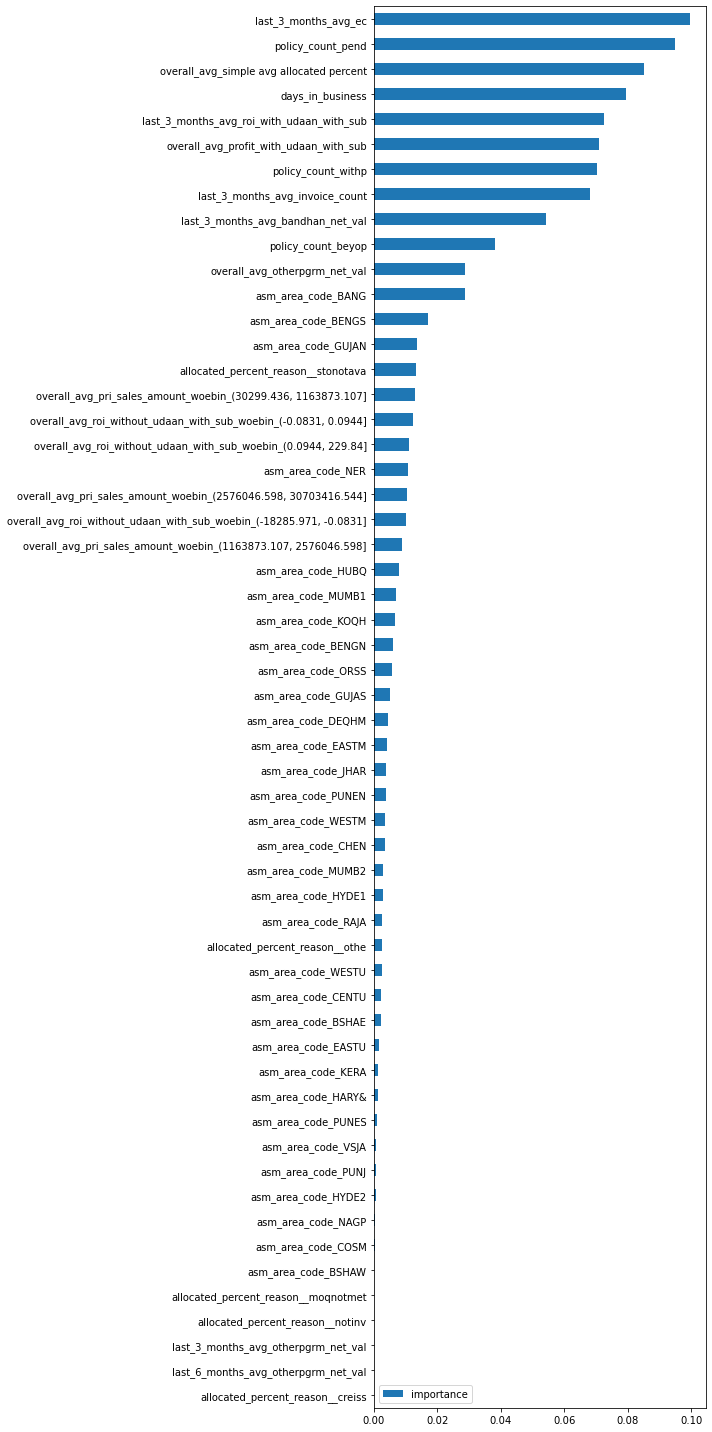

In [44]:
# Understanding the Feature Importance
imp = pd.DataFrame({'importance': rf_training_pipe_init['estimator'].feature_importances_})
imp.index = curated_columns
imp.sort_values('importance',inplace=True)

%matplotlib inline
imp.plot(kind='barh', figsize=(10,20))

Considering the top 10 features from above importances

##### Pipeline build based on new importance features

In [45]:
# let's find features for some decent defaults
imp_features = imp.tail(10).index.to_list()
estimator = RandomForestClassifier()
rf_training_pipe2 = Pipeline([
    ('', FunctionTransformer(custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('estimator', RandomForestClassifier())
])

#### Grid Search of the Estimator

In [46]:
parameters = {
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth': [4, 5],
    'criterion': ['gini', 'entropy']
}
est = RandomForestClassifier()
rf_grid = GridSearchCV(est,
                       parameters,
                       cv = 2,
                       n_jobs = 2,
                       verbose=True)

rf_grid.fit(train_X[imp_features],
            train_y)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:    3.7s finished


0.9144295302013423
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}


#### Pipeline Build using the best estimator

In [47]:
rf_pipeline_final = Pipeline([
    ('', FunctionTransformer(custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('estimator', rf_grid.best_estimator_)
])
rf_pipeline_final.fit(train_X, train_y)

reg_tree_report = ClassificationReport(model=rf_pipeline_final, x_train=train_X, y_train=train_y['target'], x_test= test_X, y_test= test_y['target'])
reg_tree_report.get_report(include_shap=False, file_path='classification_tree_model_report')

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


Confusion Matrix for a model can be obtained as follows

In [48]:
reg_tree_report.evaluator.get_confusion_matrix()

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


:HoloMap   [decision_threshold]
   :Layout
      .Table.I  :Table   [#,Actual_0,Actual_1]
      .Table.II :Table   [#,Actual_0,Actual_1]

Gains Table can be obtained as follows

In [49]:
temp=reg_tree_report.evaluator.gains_table()
temp['train'][0]

,Thresholds,bucket_size,true_positive,false_positive,true_negative,false_negative,targets_in_bucket,percent_targets_captured,lift
Bucket,,,,,,,,,
10%,0.216835,59,48,11,531,6,0.813559,0.888889,8.979284
20%,0.110344,119,54,65,477,0,0.453782,1.000000,5.008403
30%,0.072274,178,54,124,418,0,0.303371,1.000000,3.348315
40%,0.048605,238,54,184,358,0,0.226891,1.000000,2.504202
50%,0.036874,298,54,244,298,0,0.181208,1.000000,2.000000
60%,0.029526,357,54,303,239,0,0.151261,1.000000,1.669468
70%,0.020275,417,54,363,179,0,0.129496,1.000000,1.429257
80%,0.012247,476,54,422,120,0,0.113445,1.000000,1.252101
90%,0.006954,536,54,482,60,0,0.100746,1.000000,1.111940


**If we want to increase the resolution in top buckets you can customize your gains table as follows.**

The Classification report containing the feature importances are available [here](https://drive.google.com/file/d/1E_o1lz_6AqS7LLEZ6l4u94RmQWUwJvau/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [50]:
model_pipelines = [logit_ppln, rf_pipeline_final]
model_comparison_report = ClassificationComparison(models=model_pipelines,x=train_X, y=train_y)
model_comparison_report.get_report(file_path='classification_comparison')

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


In [51]:
model_comparison_report.confusion_matrices()

Nesting Layouts within a HoloMap makes it difficult to access your data or control how it appears; we recommend calling .collate() on the HoloMap in order to follow the recommended nesting structure shown in the Composing Data user guide (https://goo.gl/2YS8LJ)


:HoloMap   [decision_threshold]
   :Layout
      .Table.I  :Table   [#,Actual_0,Actual_1]
      .Table.II :Table   [#,Actual_0,Actual_1]

In [52]:
model_comparison_report.lift_charts()

:Overlay
   .Curve.Comma_estimator_left_parenthesis_0_right_parenthesis :Curve   [deciles]   (lift)
   .Curve.Comma_estimator_left_parenthesis_1_right_parenthesis :Curve   [deciles]   (lift)
   .HLine.Baseline                                             :HLine   [x,y]

In [53]:
model_comparison_report.gains_charts()

:Overlay
   .Curve.Comma_estimator_left_parenthesis_0_right_parenthesis :Curve   [deciles]   (percent_targets_captured)
   .Curve.Comma_estimator_left_parenthesis_1_right_parenthesis :Curve   [deciles]   (percent_targets_captured)
   .Curve.Baseline                                             :Curve   [deciles]   (deciles)

A report comparing the performance, metrics between Logistic model and Tree model are available [here](https://drive.google.com/file/d/1h9Yp5WhQthQq5NCKEz0NNuCxXERJZlyT/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing Random Forest model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Logistic Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat